#Environment Set-up

In [2]:
# Libraries used
import pyspark
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit
import datetime as datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as sklearnLogisticRegression
import sklearn.tree as tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier as sklearnRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as sklearnKNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler as sklearnStandardScaler
from sklearn.decomposition import PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, StandardScaler, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
##Start up Spark and SQL contexts
sc = spark.sparkContext
sqlContext = SQLContext(sc)
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.0.0 
 Master 
 spark://10.95.235.45:7077 
 AppName 
 Databricks Shell

#Dataset Exploration

##Airline Exploration

In [6]:
#Full Dataset
airlines_2015 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2015.parquet/*.parquet")
airlines_2016 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2016.parquet/*.parquet")
airlines_2017 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2017.parquet/*.parquet")
airlines_2018 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2018.parquet/*.parquet")
airlines_2019 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2019.parquet/*.parquet")
airlines_2015 = airlines_2015.drop('DIV5_TAIL_NUM')
airlines = airlines_2015.union(airlines_2016).union(airlines_2017).union(airlines_2018).union(airlines_2019)

In [7]:
#repartition ensures that there is no possibility of overlap between data splits. See: https://medium.com/udemy-engineering/pyspark-under-the-hood-randomsplit-and-sample-inconsistencies-examined-7c6ec62644bc
airlines_eda, airlines_other = airlines.repartition(20,'FL_DATE').randomSplit([0.05,0.95], seed=4)
airlines_eda = airlines_eda.toPandas()
#airlines_other = airlines_other.toPandas()

In [8]:
airlines_eda.head()

YEAR 
 QUARTER 
 MONTH 
 DAY_OF_MONTH 
 DAY_OF_WEEK 
 FL_DATE 
 OP_UNIQUE_CARRIER 
 OP_CARRIER_AIRLINE_ID 
 OP_CARRIER 
 TAIL_NUM 
 OP_CARRIER_FL_NUM 
 ORIGIN_AIRPORT_ID 
 ORIGIN_AIRPORT_SEQ_ID 
 ORIGIN_CITY_MARKET_ID 
 ORIGIN 
 ORIGIN_CITY_NAME 
 ORIGIN_STATE_ABR 
 ORIGIN_STATE_FIPS 
 ORIGIN_STATE_NM 
 ORIGIN_WAC 
 DEST_AIRPORT_ID 
 DEST_AIRPORT_SEQ_ID 
 DEST_CITY_MARKET_ID 
 DEST 
 DEST_CITY_NAME 
 DEST_STATE_ABR 
 DEST_STATE_FIPS 
 DEST_STATE_NM 
 DEST_WAC 
 CRS_DEP_TIME 
 DEP_TIME 
 DEP_DELAY 
 DEP_DELAY_NEW 
 DEP_DEL15 
 DEP_DELAY_GROUP 
 DEP_TIME_BLK 
 TAXI_OUT 
 WHEELS_OFF 
 WHEELS_ON 
 TAXI_IN 
 ... 
 DIV_DISTANCE 
 DIV1_AIRPORT 
 DIV1_AIRPORT_ID 
 DIV1_AIRPORT_SEQ_ID 
 DIV1_WHEELS_ON 
 DIV1_TOTAL_GTIME 
 DIV1_LONGEST_GTIME 
 DIV1_WHEELS_OFF 
 DIV1_TAIL_NUM 
 DIV2_AIRPORT 
 DIV2_AIRPORT_ID 
 DIV2_AIRPORT_SEQ_ID 
 DIV2_WHEELS_ON 
 DIV2_TOTAL_GTIME 
 DIV2_LONGEST_GTIME 
 DIV2_WHEELS_OFF 
 DIV2_TAIL_NUM 
 DIV3_AIRPORT 
 DIV3_AIRPORT_ID 
 DIV3_AIRPORT_SEQ_ID 
 DIV3_WHEELS_ON 
 DIV3_TOTAL_GTIME 
 DIV3_LONGEST_GTIME 
 DIV3_WHEELS_OFF 
 DIV3_TAIL_NUM 
 DIV4_AIRPORT 
 DIV4_AIRPORT_ID 
 DIV4_AIRPORT_SEQ_ID 
 DIV4_WHEELS_ON 
 DIV4_TOTAL_GTIME 
 DIV4_LONGEST_GTIME 
 DIV4_WHEELS_OFF 
 DIV4_TAIL_NUM 
 DIV5_AIRPORT 
 DIV5_AIRPORT_ID 
 DIV5_AIRPORT_SEQ_ID 
 DIV5_WHEELS_ON 
 DIV5_TOTAL_GTIME 
 DIV5_LONGEST_GTIME 
 DIV5_WHEELS_OFF 
 
 
 
 
 0 
 2015 
 1 
 1 
 5 
 1 
 2015-01-05 
 AA 
 19805 
 AA 
 N002AA 
 1298 
 11298 
 1129803 
 30194 
 DFW 
 Dallas/Fort Worth, TX 
 TX 
 48 
 Texas 
 74 
 10397 
 1039705 
 30397 
 ATL 
 Atlanta, GA 
 GA 
 13 
 Georgia 
 34 
 1820 
 1820.0 
 0.0 
 0.0 
 0.0 
 0.0 
 1800-1859 
 11.0 
 1831.0 
 2100.0 
 12.0 
 ... 
 NaN 
 None 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 None 
 None 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 None 
 None 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 
 
 1 
 2015 
 1 
 1 
 5 
 1 
 2015-01-05 
 AA 
 19805 
 AA 
 N379AA 
 7 
 11298 
 1129803 
 30194 
 DFW 
 Dallas/Fort Worth, TX 
 TX 
 48 
 Texas 
 74 
 13830 
 1383002 
 33830 
 OGG 
 Kahului, HI 
 HI 
 15 
 Hawaii 
 2 
 1215 
 1735.0 
 320.0 
 320.0 
 1.0 
 12.0 
 1200-1259 
 15.0 
 1750.0 
 2130.0 
 6.0 
 ... 
 NaN 
 None 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 None 
 None 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 None 
 None 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 
 
 2 
 2015 
 1 
 1 
 5 
 1 
 2015-01-05 
 AA 
 19805 
 AA 
 N3AAAA 
 201 
 10721 
 1072102 
 30721 
 BOS 
 Boston, MA 
 MA 
 25 
 Massachusetts 
 13 
 12892 
 1289203 
 32575 
 LAX 
 Los Angeles, CA 
 CA 
 6 
 California 
 91 
 700 
 707.0 
 7.0 
 7.0 
 0.0 
 0.0 
 0700-0759 
 16.0 
 723.0 
 1017.0 
 14.0 
 ... 
 NaN 
 None 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 None 
 None 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 None 
 None 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 
 
 3 
 2015 
 1 
 1 
 5 
 1 
 2015-01-05 
 AA 
 19805 
 AA 
 N3ADAA 
 71 
 11298 
 1129803 
 30194 
 DFW 
 Dallas/Fort Worth, TX 
 TX 
 48 
 Texas 
 74 
 14679 
 1467903 
 33570 
 SAN 
 San Diego, CA 
 CA 
 6 
 California 
 91 
 1805 
 1809.0 
 4.0 
 4.0 
 0.0 
 0.0 
 1800-1859 
 11.0 
 1820.0 
 1845.0 
 3.0 
 ... 
 NaN 
 None 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 None 
 None 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 None 
 None 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 None 
 
 
 4 
 2015 
 1 
 1 
 5 
 1 
 2015-01-05 
 AA 
 19805 
 AA 
 N3ADAA 
 1511 
 11697 
 1169703 
 32467 
 FLL 
 Fort Lauderdale, FL 
 FL 
 12 
 Florida 
 33 
 11298 
 1129803 
 30194 
 DFW 
 Dallas/Fort Worth, TX 
 TX 
 48 
 Texas 
 74 
 1445 
 1503.0 
 18.0 
 18.0 
 1.0 
 1.0 
 1400-1459 
 19.0 
 1522.0 
 1704.0 
 9.0 
 ... 
 NaN 

In [9]:
airlines_eda.describe()

YEAR 
 QUARTER 
 MONTH 
 DAY_OF_MONTH 
 DAY_OF_WEEK 
 OP_CARRIER_AIRLINE_ID 
 OP_CARRIER_FL_NUM 
 ORIGIN_AIRPORT_ID 
 ORIGIN_AIRPORT_SEQ_ID 
 ORIGIN_CITY_MARKET_ID 
 ORIGIN_STATE_FIPS 
 ORIGIN_WAC 
 DEST_AIRPORT_ID 
 DEST_AIRPORT_SEQ_ID 
 DEST_CITY_MARKET_ID 
 DEST_STATE_FIPS 
 DEST_WAC 
 CRS_DEP_TIME 
 DEP_TIME 
 DEP_DELAY 
 DEP_DELAY_NEW 
 DEP_DEL15 
 DEP_DELAY_GROUP 
 TAXI_OUT 
 WHEELS_OFF 
 WHEELS_ON 
 TAXI_IN 
 CRS_ARR_TIME 
 ARR_TIME 
 ARR_DELAY 
 ARR_DELAY_NEW 
 ARR_DEL15 
 ARR_DELAY_GROUP 
 CANCELLED 
 DIVERTED 
 CRS_ELAPSED_TIME 
 ACTUAL_ELAPSED_TIME 
 AIR_TIME 
 FLIGHTS 
 DISTANCE 
 DISTANCE_GROUP 
 CARRIER_DELAY 
 WEATHER_DELAY 
 NAS_DELAY 
 SECURITY_DELAY 
 LATE_AIRCRAFT_DELAY 
 FIRST_DEP_TIME 
 TOTAL_ADD_GTIME 
 LONGEST_ADD_GTIME 
 DIV_AIRPORT_LANDINGS 
 DIV_REACHED_DEST 
 DIV_ACTUAL_ELAPSED_TIME 
 DIV_ARR_DELAY 
 DIV_DISTANCE 
 DIV1_AIRPORT_ID 
 DIV1_AIRPORT_SEQ_ID 
 DIV1_WHEELS_ON 
 DIV1_TOTAL_GTIME 
 DIV1_LONGEST_GTIME 
 DIV1_WHEELS_OFF 
 DIV2_AIRPORT_ID 
 DIV2_AIRPORT_SEQ_ID 
 DIV2_WHEELS_ON 
 DIV2_TOTAL_GTIME 
 DIV2_LONGEST_GTIME 
 DIV2_WHEELS_OFF 
 DIV3_AIRPORT_ID 
 DIV3_AIRPORT_SEQ_ID 
 DIV3_WHEELS_ON 
 DIV3_TOTAL_GTIME 
 DIV3_LONGEST_GTIME 
 
 
 
 
 count 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.587235e+06 
 1.563659e+06 
 1.563404e+06 
 1.563404e+06 
 1.563404e+06 
 1.563404e+06 
 1.562951e+06 
 1.562952e+06 
 1.562120e+06 
 1.562120e+06 
 1.587235e+06 
 1.562120e+06 
 1.558714e+06 
 1.558714e+06 
 1.558714e+06 
 1.558714e+06 
 1.587235e+06 
 1.587235e+06 
 1.587231e+06 
 1.558857e+06 
 1.558857e+06 
 1587235.0 
 1.587235e+06 
 1.587235e+06 
 289045.000000 
 289045.000000 
 289045.000000 
 289045.000000 
 289045.000000 
 10331.000000 
 10331.000000 
 10331.000000 
 1.587235e+06 
 3915.000000 
 3263.000000 
 3263.000000 
 3915.000000 
 4095.000000 
 4.095000e+03 
 4095.000000 
 4095.000000 
 4095.000000 
 3285.000000 
 32.000000 
 3.200000e+01 
 32.000000 
 32.00000 
 32.000000 
 10.000000 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 mean 
 2.017150e+03 
 2.517939e+00 
 6.553057e+00 
 1.575695e+01 
 3.933438e+00 
 1.994927e+04 
 2.338832e+03 
 1.266898e+04 
 1.266901e+06 
 3.172841e+04 
 2.635721e+01 
 5.487709e+01 
 1.266709e+04 
 1.266712e+06 
 3.172791e+04 
 2.637265e+01 
 5.489562e+01 
 1.329407e+03 
 1.333630e+03 
 9.862322e+00 
 1.291928e+01 
 1.818583e-01 
 3.604251e-02 
 1.683085e+01 
 1.356444e+03 
 1.464099e+03 
 7.554336e+00 
 1.488374e+03 
 1.468516e+03 
 4.605875e+00 
 1.296894e+01 
 1.854381e-01 
 -2.108398e-01 
 1.541297e-02 
 2.466553e-03 
 1.432363e+02 
 1.382433e+02 
 1.138705e+02 
 1.0 
 8.233107e+02 
 3.765570e+00 
 20.174326 
 3.222055 
 15.396215 
 0.092570 
 25.430359 
 1341.677476 
 37.342852 
 36.819669 
 3.504207e-03 
 0.833461 
 375.169782 
 227.880478 
 46.552235 
 12722.461050 
 1.272249e+06 
 1507.040781 
 34.915018 
 28.286447 
 1569.595738 
 12539.187500 
 1.253922e+06 
 1584.937500 
 17.75000 
 14.625000 
 1680.100000 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 std 
 1.431084e+00 
 1.105258e+00 
 3.399592e+00 
 8.774643e+00 
 1.992501e+00 
 3.832587e+02 
 1.791680e+03 
 1.526936e+03 
 1.526933e+05 
 1.289381e+03 
 1.653052e+01 
 2.657314e+01 
 1.526815e+03 
 1.526813e+05 
 1.288662e+03 
 1.653509e+01 
 2.657055e+01 
 4.895389e+02 
 5.030245e+02 
 4.369007e+01 
 4.262916e+01 
 3.857278e-01 
 2.163371e+00 
 9.479909e+00 
 5.046595e+02 
 5.316191e+02 
 5.920426e+00 
 5.165098e+02 
 5.359670e+02 
 4.578426e+01 
 4.233951e+01 
 3.886527e-01 
 2.299048e+00 
 1.231885e-01 
 4.960314e-02 
 7.475826e+01 
 7.434874e+01 
 7.224781e+01 
 0.0 
 6.077520e+02 
 2.391980e+00 
 60.472558 
 26.612899 
 34.663653 
 2.962323 
 48.467320 
 504.047073 
 32.989314 
 31.989533 
 1.081254e-01 
 0.372611 
 187.085353 
 185.006666 
 187.974039 
 1598.947012 
 1.598945e+05 
 562.154433 
 32.707227 
 29.1

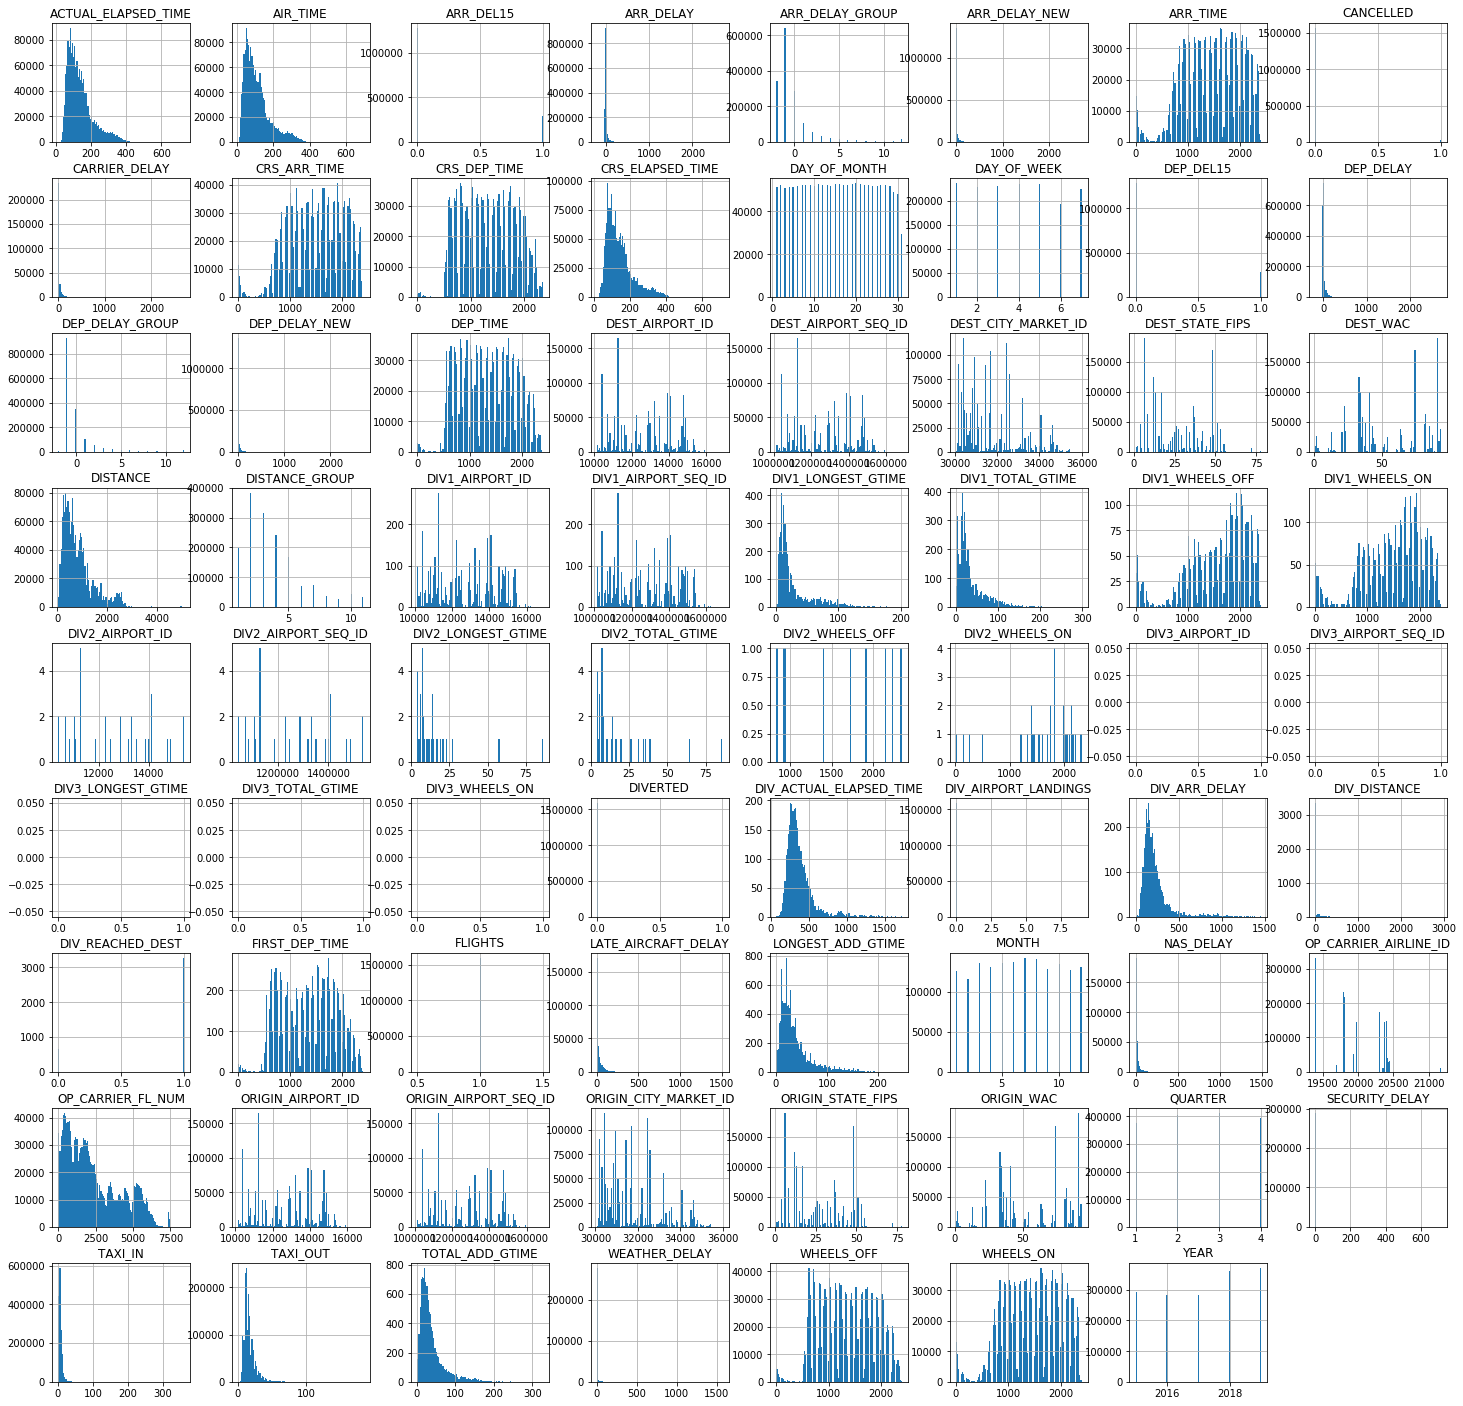

In [10]:
airlines_eda.hist(figsize=(25,25), bins=110)

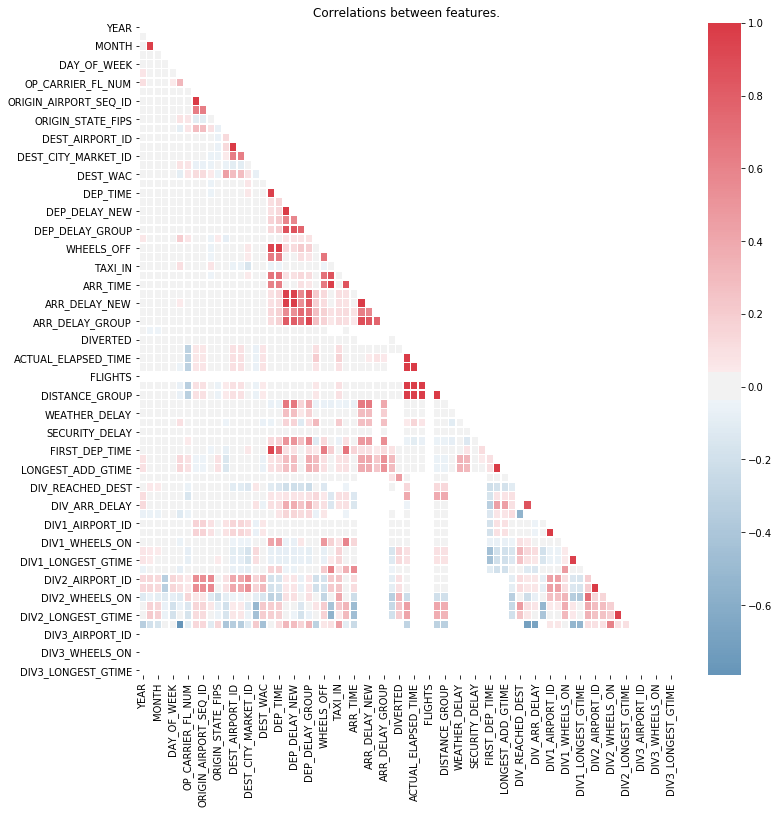

In [11]:
##Correlation Matrix
air_corr = airlines_eda.corr()
fig, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(air_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sn.diverging_palette(240, 10, as_cmap=True)
sn.heatmap(air_corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
display(plt.show())

#### Discussion of flight data variables

* Exclusion
  * The variables beginning with DIV2, DIV3, DIV4, and DIV5 are completely empty
  * All variables with SEQ_ID contain unique identifiers at a given point in time. For our purposes, this is less useful and redundant to the more generalizable fields with the same information applicable across time
  * ORIGIN, ORIGIN_CITY_NAME, ORIGIN_STATE_FIPS, ORIGIN_STATE_NM and the corresponding fields for DEST are all redundant with other fields that we will retain that identify airport ID, city, market and state

##Weather Exploration

In [14]:
#Sample Dataset
#weather = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/*.parquet")
#Full Dataset
weather_2015 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/*.parquet")
weather_2016 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2016a.parquet/*.parquet")
weather_2017 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2017a.parquet/*.parquet")
weather_2018 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2018a.parquet/*.parquet")
weather_2019 = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2019a.parquet/*.parquet")
weather = weather_2015.union(weather_2016).union(weather_2017).union(weather_2018).union(weather_2019)

In [15]:
weather_eda, weather_other = weather.randomSplit([0.0001,0.9999], seed=4)
weather_eda = weather_eda.toPandas()

In [16]:
weather_eda.head()

STATION 
 DATE 
 SOURCE 
 LATITUDE 
 LONGITUDE 
 ELEVATION 
 NAME 
 REPORT_TYPE 
 CALL_SIGN 
 QUALITY_CONTROL 
 WND 
 CIG 
 VIS 
 TMP 
 DEW 
 SLP 
 AW1 
 GA1 
 GA2 
 GA3 
 GA4 
 GE1 
 GF1 
 KA1 
 KA2 
 MA1 
 MD1 
 MW1 
 MW2 
 OC1 
 OD1 
 OD2 
 REM 
 EQD 
 AW2 
 AX4 
 GD1 
 AW5 
 GN1 
 AJ1 
 ... 
 GA6 
 KG1 
 AU3 
 AT7 
 KD1 
 GL1 
 IA1 
 GG2 
 OD3 
 UG1 
 CB1 
 AI6 
 CI1 
 CV2 
 AZ2 
 AD1 
 AH1 
 WD1 
 AA4 
 KC1 
 IA2 
 CF3 
 AI2 
 AT1 
 GD4 
 AX3 
 AH4 
 KB3 
 CU1 
 CN4 
 AT2 
 CG1 
 CF1 
 GG1 
 MV2 
 CW1 
 GG4 
 AB1 
 AH5 
 CN3 
 
 
 
 
 0 
 None 
 2015-01-20 13:55:00 
 6.0 
 40.05361 
 -106.36889 
 2258.9 
 KREMMLING MCELROY AIRFIELD, CO US 
 FM-15 
 K20V 
 V020 
 270,5,N,0041,5 
 01311,5,M,N 
 016093,5,N,5 
 -0020,C 
 -0100,C 
 99999,9 
 
 04,5,+00732,5,99,9 
 04,5,+01067,5,99,9 
 07,5,+01311,5,99,9 
 
 
 
 
 
 10217,5,07763,5 
 
 
 
 0088,5 
 
 
 MET09501/20/15 06:55:02 METAR K20V 201355Z 270... 
 R01 M027TMP046R02 M107DPT046 
 
 
 2,99,1,+00732,5,9 
 
 
 
 ... 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 None 
 2015-01-22 00:15:00 
 6.0 
 30.21889 
 -96.37417 
 93.9 
 BRENHAM MUNICIPAL AIRPORT, TX US 
 FM-15 
 K11R 
 V020 
 070,5,N,0015,5 
 22000,5,9,N 
 016093,5,N,5 
 +0166,5 
 +0140,5 
 99999,9 
 61,5 
 04,5,+00610,5,99,9 
 
 
 
 
 
 
 
 10179,5,10067,5 
 
 
 
 
 
 
 MET09001/21/15 18:15:01 METAR K11R 220015Z 070... 
 
 
 
 2,99,1,+00610,5,9 
 
 
 
 ... 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2 
 None 
 2015-02-11 08:15:00 
 6.0 
 29.90778 
 -96.95000 
 98.8 
 FAYETTE REGIONAL AIR CENTER AIRPORT, TX US 
 FM-15 
 K3T5 
 V020 
 180,5,N,0041,5 
 00061,5,M,N 
 006437,5,N,5 
 +0143,5 
 +0142,5 
 99999,9 
 10,5 
 08,5,+00061,5,99,9 
 
 
 
 
 
 
 
 10146,5,10027,5 
 
 
 
 
 
 
 MET08802/11/15 02:15:02 METAR K3T5 110815Z 180... 
 
 
 
 4,99,1,+00061,5,9 
 
 
 
 ... 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3 
 None 
 2015-03-30 10:15:00 
 6.0 
 30.21889 
 -96.37417 
 93.9 
 BRENHAM MUNICIPAL AIRPORT, TX US 
 FM-15 
 K11R 
 V020 
 999,9,C,0000,5 
 00945,5,M,N 
 016093,5,N,5 
 +0188,5 
 +0180,5 
 99999,9 
 
 07,5,+00945,5,99,9 
 
 
 
 
 
 
 
 10203,5,10090,5 
 
 
 
 
 
 
 MET08603/30/15 04:15:02 METAR K11R 301015Z 000... 
 
 
 
 3,99,1,+00945,5,9 
 
 
 
 ... 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4 
 None 
 2015-04-16 16:55:00 
 6.0 
 30.07194 
 -83.57361 
 13.7 
 PERRY FOLEY AIRPORT, FL US 
 FM-15 
 K40J 
 V020 
 040,5,N,0021,5 
 01006,5,M,N 
 016093,5,N,5 
 +0227,5 
 +0210,5 
 99999,9 
 61,5 
 04,5,+00335,5,99,9 
 04,5,+00823,5,99,9 
 07,5,+01006,5,99,9 
 
 
 
 
 
 10207,5,10190,5 
 
 
 
 
 
 
 MET10404/16/15 11:55:02 METAR K40J 161655Z 040... 
 
 
 
 2,99,1,+00335,5,9 
 
 
 
 ... 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5 rows × 177 columns

## Weather columns
- AA - liquid precipitation - depth (milimeters - index 1) - USE THIS ONE
- AB - liquid precipitation monthly total - depth (milimeters - index 0)
- AD - liquid precipitation greatest amount in 24 hours for the month (milimeters - index 0)
- AE - liquid precipitation number of days with specific amount 
- AH - liquid precipitation max short duration for the month
- AI - identical to above
- AJ - snow depth - centimeters - index 0 - USE THIS ONE
- AK - snow depth, greatest depth on the ground for the month - depth (centimeters - index 0)
- AM - snow depth, greatest amount in 24 hour period - depth (centimeters - index 0)
- AT - Present weather observation - categorical - index 1 - USE THIS ONE
- AW - Present weather observation - categorical - index 0
- AX - Past weather observation - categorical - index 0 - USE THIS ONE
- ED - Runway visual range - meters - index 2 - USE THIS ONE
- GA - Sky cover layer - Height of lowest surface of a cloud (meters - index2)
- GD - Sky cover summation - categorical - index 0 - USE THIS ONE
- GF - Sky condition observation - total coverage code - categorical
- KA - Extreme air temperature - celsius - index 2 - USE THIS ONE
- KB - Average air temperature - celsius - index 2 - USE THIS ONE
- KC - Extreme air temperature for the month - celsius - index 2
- KD - Heating cooling degree days
- KG - Average Dew Point - celsius - index 2
- MA - Atmospheric pressure - hectopascals - index 0 - USE THIS ONE
- MD - Atmospheric pressure Change three hour quantity - hectopascals - index 2 - USE THIS ONE
- MF - Atmospheric pressure average station pressure for the day - hectopascals - index 0 - USE THIS ONE
- MG - Atmospheric pressure average station pressure for the day
- MH - Atmospheric pressure average station pressure for the month
- MK - Atmospheric pressure for the month
- MW - present weather observation 
- OC - Wind Gust - meters per second - index 0 - USE THIS ONE
- OD - Supplementary wind observatoin
- OE - Summary of the day Wind - meters per second - index 0 - USE THIS ONE
- RH - Relative Humidity - percent - index 2 - USE THIS ONE
- WA - Ice Accretion - centimeters - index 1 - USE THIS ONE

## Other columns to use :
- AA - Liquid Precipitation - The identifier that represents an episode of LIQUID-PRECIPITATION - depth in millimeters
- AJ - Snow Depth - The identifier that denotes the start of a SNOW-DEPTH data section - depth in centimeters
- AT - Present Weather Observation - The identifier that signifies the reporting of present weather - Categorical
> Categories
>> 01 = Fog, ice fog or freezing fog (may include heavy fog) 
>> 02 = Heavy fog or heavy freezing fog (not always distinguished from fog)
>> 03 = Thunder
>> 04 = Ice pellets, sleet, snow pellets or small hail
>> 05 = Hail (may include small hail)
>> 06 = Glaze or rime
>> 07 = Dust, volcanic ash, blowing dust, blowing sand or blowing obstruction
>> 08 = Smoke or haze
>> 09 = Blowing or drifting snow
>> 10 = Tornado, water spout or funnel cloud
>> 11 = High or damaging winds
>> 12 = Blowing spray
>> 13 = Mist
>> 14 = Drizzle
>> 15 = Freezing drizzle
>> 16 = Rain
>> 17 = Freezing rain
>> 18 = Snow, snow pellets, snow grains or ice crystals
>> 19 = Unknown precipitation
>> 21 = Ground fog
>> 22 = Ice fog or freezing fog
- AX - Past Weather Observation - The identifier that signifies the reporting of past weather as summarized for the calendar day - Categorical
> Categories
>> 00 = none to report 
>> 01 = fog
>> 02 = fog reducing visibility to ¼ mile or less
>> 03 = thunder
>> 04 = ice pellets
>> 05 = hail
>> 06 = glaze or rime
>> 07 = blowing dust or sand, visibility ½ mile or less
>> 08 = smoke or haze
>> 09 = blowing snow
>> 10 = tornado
>> 11 = high or damaging winds
>> 99 = missing
- ED - Runway Visual Range - The dimension of the horizontal distance that can be seen along the runway - meters
- GD - Sky Cover Summation - The code that denotes the portion of the total celestial dome covered by all layers of clouds and other - Categorical
> Categories
>> 0 = Clear - No coverage
 1 = FEW - 2/8 or less coverage (not including zero)
 2 = SCATTERED - 3/8-4/8 coverage
 3 = BROKEN - 5/8-7/8 coverage
 4 = OVERCAST - 8/8 coverage
 5 = OBSCURED
 6 = PARTIALLY OBSCURED
 9 = MISSING
- KA - Extreme Air Temperature - The temperature of the high or low air temperature for a given period - degrees celsius
- KB - Average Air Temperature - The mean air temperature for a given period, typically for the day or month, as reported by the station - degrees celsius
- MA - Atmospheric Pressure Observation - The atmospheric pressure at the observation point - hectopascals
- MD - Atmospheric Pressure Change - The absolute value of the quantity of change in atmospheric pressure measured at the beginning and end of a three hour period - hectopascals
- MF - Atmospheric Pressure Observation - The average pressure at the observed point for the day derived computationally from other QC’ed elements - hectopascals
- OC - Wind Gust - The rate of speed of a wind gust - meters per second
- OE - Summary of Day Wind Observation - The rate of horizontal wind speed of air reported in the SUMMARY-OF-DAY-WIND-OBSERVATION - meters per second
- RH - Relative Humidity - The average maximum or minimum relative humidity for a given period, typically for the day or month, derived from other data fields - percent
- WA - Ice Accretion - The thickness of the ice that has accumulated on a marine platform - centimeters

##Stations Exploration

In [20]:
stations = spark.read.option("header", "true").csv("dbfs:/mnt/mids-w261/data/DEMO8/gsod/stations.csv.gz")

In [21]:
stations = stations.toPandas()

In [22]:
stations.head()

usaf 
 wban 
 name 
 country 
 state 
 call 
 lat 
 lon 
 elev 
 begin 
 end 
 
 
 
 
 0 
 007018 
 99999 
 WXPOD 7018 
 None 
 None 
 None 
 0 
 0 
 +7018.0 
 20110309 
 20130730 
 
 
 1 
 007026 
 99999 
 WXPOD 7026 
 AF 
 None 
 None 
 0 
 0 
 +7026.0 
 20120713 
 20170822 
 
 
 2 
 007070 
 99999 
 WXPOD 7070 
 AF 
 None 
 None 
 0 
 0 
 +7070.0 
 20140923 
 20150926 
 
 
 3 
 008268 
 99999 
 WXPOD8278 
 AF 
 None 
 None 
 32.95 
 65.567 
 +1156.7 
 20100519 
 20120323 
 
 
 4 
 008307 
 99999 
 WXPOD 8318 
 AF 
 None 
 None 
 0 
 0 
 +8318.0 
 20100421 
 20100421

##Small Dataset Exploration

In [24]:
#Smaller Dataset
airlines_small = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data_3m/*.parquet")
airlines_small = airlines_small.toPandas()

In [25]:
# DEP_DEL15: Fill in O in NaN value
airlines_small['DEP_DEL15'] = airlines_small['DEP_DEL15'].fillna(0)
airlines_small['DELAY_15'] = airlines_small.DEP_DEL15

# Get the rows of canceled flights
cancel_index = airlines_small.loc[airlines_small['CANCELLED'] == 1].index

# When the flight is canceled assign DELAY_15 as 0
airlines_small.iloc[cancel_index,-1] = 0

In [26]:
# delete time period redundant variables
del_list_time_period = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK']

for col in del_list_time_period:
  del airlines_small[col]

# delete origin related redundant variables
del_list_origin = ['ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC']

for col in del_list_origin:
  del airlines_small[col]
  
# delete destination related redundant variables
del_list_dest = ['DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC']

for col in del_list_dest:
  del airlines_small[col]
  
del_list_dest_perf = ['DEP_DELAY', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK']

for col in del_list_dest_perf:
  del airlines_small[col]
  
# delete arrival performance related redundant variables
del_list_arr_perf = ['ARR_DELAY', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK']

for col in del_list_arr_perf:
  del airlines_small[col]

# delete flight summaries related redundant variables
del airlines_small['DISTANCE_GROUP']

# delete diverted airport information related redundant variables
del_list_div_info = ['DIV4_AIRPORT', 'DIV4_AIRPORT_ID', 'DIV4_AIRPORT_SEQ_ID', 'DIV4_WHEELS_ON', 'DIV4_TOTAL_GTIME', 'DIV4_LONGEST_GTIME', 'DIV4_WHEELS_OFF', 'DIV4_TAIL_NUM', 'DIV5_AIRPORT', 'DIV5_AIRPORT_ID', 'DIV5_AIRPORT_SEQ_ID', 'DIV5_WHEELS_ON', 'DIV5_TOTAL_GTIME', 'DIV5_LONGEST_GTIME', 'DIV5_WHEELS_OFF', 'DIV5_TAIL_NUM']

for col in del_list_div_info:
  del airlines_small[col]
  
# delete outcome related variables
del_list_outcome_related = ['DEP_DELAY_NEW', 'ARR_DELAY_NEW']

for col in del_list_outcome_related:
  del airlines_small[col]


In [27]:
# Assign the value of ADJ_DEP_TIME as DEP_TIME
airlines_small['ADJ_DEP_TIME'] = airlines_small.DEP_TIME

# Set NaN value in ADJ_DEP_TIME variable in canceled flight.
airlines_small.loc[airlines_small['CANCELLED'] == 1, 'ADJ_DEP_TIME'] = np.nan

In [28]:
# Get continuous variables
X_continuous =airlines_small[['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE']]
X_continuous.head()

# Standardizing the continuous variables
X = sklearnStandardScaler().fit_transform(X_continuous)
X[np.isnan(X)] = 0

# Use PCA, reduce the feature vector to 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
df_principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# get non-continuous variables
airlines_small_non_continuous = airlines_small.drop(['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE'], axis=1)

# concat airlines PCA continuous and non-continuous variables
airlines_small_pca = pd.concat([airlines_small_non_continuous, df_principal], axis=1)

In [29]:
#Sample Dataset
weather_small = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/*.parquet")
weather_small = weather_small.where(f.col("CALL_SIGN").isin({"KATL ", "KORD "}))

weather_small = weather_small.toPandas()

In [30]:
weather_small.loc[weather_small['CALL_SIGN'] == 'KATL ', 'ORIGIN'] = 'ATL' 
weather_small.loc[weather_small['CALL_SIGN'] == 'KORD ', 'ORIGIN'] = 'ORD' 

# Add 2 hours in weather data because we want the predict the delay 2 hours before departure. Add DEP_HOUR and DEP_DATE columns in weather to represent the departure time
weather_small['DEP_HOUR'] = weather_small.DATE.map(lambda x: (x + datetime.timedelta(hours=2)).hour)
weather_small['FL_DATE'] = weather_small.DATE.map(lambda x: (x + datetime.timedelta(hours=2)).date())

#delete all columns that are blank
cols_to_delete = ['GA4','MW2','OD2','GN1','GG3','AU5','HL1','OB1','AT8','AW7','AZ1','CH1','GK1','IB1','CT1','CN2','MW5','AO1','CR1','CF2','GM1','AY2','MW6',
                 'AL2','AL3','AX5','IB2','CV3','GH1','KF1','CU2','CT3','SA1','GO1','CG3','AL1','AW6','MW4','AX6','CV1','ME1','CN1','UA1','GD5','UG2','GJ1','MV1',
                 'GA5','CT2','CG2','CO1','MW3','AY1','CU3','GA6','GL1','IA1','GG2','OD3','UG1','CB1','CI1','CV2','AZ2','WD1','AA4','IA2','CF3','CU1','CN4','CG1',
                 'CF1','GG1','MV2','CW1','GG4','CN3','QUALITY_CONTROL']
for col in cols_to_delete:
  del weather_small[col]
  
#Delete redundant columns
cols_to_delete1 = ['AB1','AD1','AE1','AK1','AH1','AH2','AH3','AH4','AH5','AH6','AI1','AI2','AI3','AI4',"AI5",'AI6','AM1','AU1','AU2','AU3','AU4',"AW1",'AW2','AW3','AW4','AW5','KC1','KC2','KD1',
                   'KD2','KE1','KG1','KG2','GA1','GA2','GA3','GE1','GF1','MH1','MG1','MK1','MW1','OD1',]
for col in cols_to_delete1:
  del weather_small[col]

In [31]:
#funciton to combine colomns, eg AA1, AA2, AA3 etc.
def combine_columns(df, col1, col2):
  mask = df[col2] != ""
  df.loc[mask, col1] = df[col2]
  del df[col2]
  return df

In [32]:
df_weather = combine_columns(weather_small, 'AA1','AA2')
df_weather = combine_columns(weather_small, 'AA1','AA3')
df_weather = combine_columns(weather_small, 'AT1','AT2')
df_weather = combine_columns(weather_small, 'AT1','AT3')
df_weather = combine_columns(weather_small, 'AT1','AT4')
df_weather = combine_columns(weather_small, 'AT1','AT5')
df_weather = combine_columns(weather_small, 'AT1','AT6')
df_weather = combine_columns(weather_small, 'AT1','AT7')
df_weather = combine_columns(weather_small, 'AX1','AX2')
df_weather = combine_columns(weather_small, 'AX1','AX3')
df_weather = combine_columns(weather_small, 'AX1','AX4')
df_weather = combine_columns(weather_small, 'GD1','GD2')
df_weather = combine_columns(weather_small, 'GD1','GD3')
df_weather = combine_columns(weather_small, 'GD1','GD4')
df_weather = combine_columns(weather_small, 'KA1','KA2')
df_weather = combine_columns(weather_small, 'KA1','KA3')
df_weather = combine_columns(weather_small, 'KA1','KA4')
df_weather = combine_columns(weather_small, 'KB1','KB2')
df_weather = combine_columns(weather_small, 'KB1','KB3')
df_weather = combine_columns(weather_small, 'OE1','OE2')
df_weather = combine_columns(weather_small, 'OE1','OE3')
df_weather = combine_columns(weather_small, 'RH1','RH2')
df_weather = combine_columns(weather_small, 'RH1','RH3')


In [33]:
#pull out the correct feature of the variable using index
cols_to_condense0 = ['AJ1','AX1','GD1','MF1','OC1','CIG','VIS']
cols_to_condense1 = ['AA1','AN1','AT1','WA1']
cols_to_condense2 = ['ED1','KA1','KB1','MA1','MD1','OE1','RH1']
cols_to_condense3 = ['WND']

def condense_col(df, col_name,num):
  df[col_name] = df[col_name].str.split(',').str[num]
  return df

for x in cols_to_condense0:
  weather_small = condense_col(weather_small, x, 0)
for y in cols_to_condense1:
  weather_small = condense_col(weather_small, y, 1)
for z in cols_to_condense2:
  weather_small = condense_col(weather_small, z, 2)
for a in cols_to_condense3:
  weather_small = condense_col(weather_small, a, 3)
  
#get rid of nans
weather_small = weather_small.fillna(0)

In [34]:
Y_continuous = weather_small[['AA1','AJ1','ED1','KA1','KB1','MA1','MD1','MF1','OC1','OE1','RH1','WA1']]

Y_continuous["AA1"] = pd.to_numeric(Y_continuous["AA1"], downcast="float")
Y_continuous["AJ1"] = pd.to_numeric(Y_continuous["AJ1"], downcast="float")
Y_continuous["ED1"] = pd.to_numeric(Y_continuous["ED1"], downcast="float")
Y_continuous["KA1"] = pd.to_numeric(Y_continuous["KA1"], downcast="float")
Y_continuous["KB1"] = pd.to_numeric(Y_continuous["KB1"], downcast="float")
Y_continuous["MA1"] = pd.to_numeric(Y_continuous["MA1"], downcast="float")
Y_continuous["MD1"] = pd.to_numeric(Y_continuous["MD1"], downcast="float")
Y_continuous["MF1"] = pd.to_numeric(Y_continuous["MF1"], downcast="float")
Y_continuous["OC1"] = pd.to_numeric(Y_continuous["OC1"], downcast="float")
Y_continuous["OE1"] = pd.to_numeric(Y_continuous["OE1"], downcast="float")
Y_continuous["RH1"] = pd.to_numeric(Y_continuous["RH1"], downcast="float")
Y_continuous["WA1"] = pd.to_numeric(Y_continuous["WA1"], downcast="float")

Y_continuous = Y_continuous.fillna(0)



/local_disk0/tmp/1596832321985-0/PythonShell.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 
/local_disk0/tmp/1596832321985-0/PythonShell.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import errno
/local_disk0/tmp/1596832321985-0/PythonShell.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import linecache
/local_disk0/tmp/1596832321985-0/PythonShell.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import os
/local_disk0/tmp/1596832321985-0/PythonShell.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import pickle
/local_disk0/tmp/1596832321985-0/PythonShell.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import resource
/local_disk0/tmp/1596832321985-0/PythonShell.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import signal
/local_disk0/tmp/1596832321985-0/PythonShell.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import six
/local_disk0/tmp/1596832321985-0/PythonShell.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import six.moves.queue
/local_disk0/tmp/1596832321985-0/PythonShell.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import subprocess
/local_disk0/tmp/1596832321985-0/PythonShell.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import sys
/local_disk0/tmp/1596832321985-0/PythonShell.py:14: SettingWithCopyWarning: 
A value is trying to be set on 

In [35]:
Y = sklearnStandardScaler().fit_transform(Y_continuous)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(Y)
df_principal1 = pd.DataFrame(data = principalComponents
             , columns = ['weather principal component 1', 'weather principal component 2']).fillna(0)

# get non-continuous variables
weather_small_non_continuous = weather_small.drop(['AA1','AJ1','ED1','KA1','KB1','MA1','MD1','MF1','OC1','OE1','RH1','WA1'], axis=1)

# concat weather PCA continuous and non-continuous variables
weather_small_pca = pd.concat([weather_small_non_continuous, df_principal1], axis=1)

In [36]:
# When the row do not have departure time in ADJ_DEP_TIME than drop it
airlines_small_pca = airlines_small_pca.drop(airlines_small_pca[airlines_small_pca.ADJ_DEP_TIME.isna()].index)

# Extract the departure hour and date from ADJ_DEP_TIME column
airlines_small_pca['DEP_HOUR'] = airlines_small_pca.ADJ_DEP_TIME.map(lambda x: str(x)[0:-4])

airlines_small_pca['FL_DATE'] = pd.to_datetime(airlines_small_pca.FL_DATE).apply(lambda x: x.date())

weather_small_pca['DEP_HOUR'] = weather_small_pca.DEP_HOUR.astype(str)

weather_small_unique = weather_small_pca.drop_duplicates(['DEP_HOUR','FL_DATE','ORIGIN'])

# left join of airline and weather data by location and time
df = pd.merge(airlines_small_pca, weather_small_unique, how='inner', on=['ORIGIN', 'FL_DATE', 'DEP_HOUR'])

In [37]:
## Training, Test, Holdout Splits
train_test_df, holdout_df = train_test_split(df, test_size=0.2, random_state = 42)
train_df, test_df = train_test_split(train_test_df, test_size=0.25, random_state = 42)

x_vars = ['CANCELLED','principal component 1','principal component 2', 'weather principal component 1','weather principal component 2']
X = train_test_df[x_vars]
y = train_test_df['DELAY_15']
X_test = test_df[x_vars]
y_test = test_df['DELAY_15']
X_train = train_df[x_vars]
y_train = train_df['DELAY_15']
random_state = 42
leaf_n_dict = {}
knn_n_dict = {}
logreg_setup_ls = [('liblinear','l1'),('liblinear','l2')]

In [38]:
for solver,penalty in logreg_setup_ls:
  f1_scores = cross_val_score(sklearnLogisticRegression(random_state=42, solver=solver, penalty=penalty),X,y,cv=5, scoring='f1')
  acc_scores = cross_val_score(sklearnLogisticRegression(random_state=42, solver=solver, penalty=penalty),X,y,cv=5, scoring='accuracy')
  prec_scores = cross_val_score(sklearnLogisticRegression(random_state=42, solver=solver, penalty=penalty),X,y,cv=5, scoring='precision')
  rec_scores = cross_val_score(sklearnLogisticRegression(random_state=42, solver=solver, penalty=penalty),X,y,cv=5, scoring='recall')
  
  print(f"F1 scores for {penalty} Logistic Regression: ",f1_scores)
  print(f"Accuracy scores for {penalty} Logistic Regression: ",acc_scores)
  print(f"Precision scores for {penalty} Logistic Regression: ",prec_scores)
  print(f"Recall scores for {penalty} Logistic Regression: ",rec_scores)

F1 scores for l1 Logistic Regression: [0.01356852 0.01860937 0.01357082 0.0182772 0.01760325]
Accuracy scores for l1 Logistic Regression: [0.7668751 0.76747635 0.76691518 0.76747635 0.76734678]
Precision scores for l1 Logistic Regression: [1. 1. 1. 1. 0.98113208]
Recall scores for l1 Logistic Regression: [0.0068306 0.00939208 0.00683177 0.00922289 0.0088813 ]
F1 scores for l2 Logistic Regression: [0.01390538 0.01860937 0.01357082 0.0182772 0.01760325]
Accuracy scores for l2 Logistic Regression: [0.76691518 0.76747635 0.76691518 0.76747635 0.76734678]
Precision scores for l2 Logistic Regression: [1. 1. 1. 1. 0.98113208]
Recall scores for l2 Logistic Regression: [0.00700137 0.00939208 0.00683177 0.00922289 0.0088813 ]

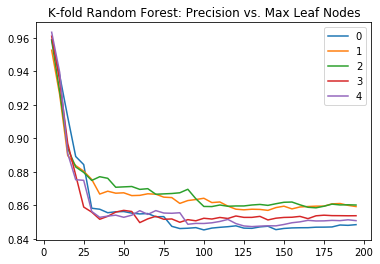

In [39]:
def randomforestmodeler(random_state, leaf_n):
  model = sklearnRandomForestClassifier(random_state=random_state, max_leaf_nodes=leaf_n, n_estimators=10)
  scores = cross_val_score(model, X,y,cv=5, scoring='precision')
  leaf_n_dict[leaf_n] = scores
  
leafs_ls = [x*5 for x in range(1,40)]
for leaf_n in leafs_ls:
  randomforestmodeler(random_state, leaf_n)
pd.DataFrame.from_dict(leaf_n_dict, orient='index').plot(title='K-fold Random Forest: Precision vs. Max Leaf Nodes')

In [40]:
acc_scores = cross_val_score(sklearnRandomForestClassifier(random_state=random_state, max_leaf_nodes=10, n_estimators=10),X,y,cv=5,scoring='accuracy')
prec_scores = cross_val_score(sklearnRandomForestClassifier(random_state=random_state, max_leaf_nodes=10, n_estimators=10),X,y,cv=5,scoring='precision')
f1_scores = cross_val_score(sklearnRandomForestClassifier(random_state=random_state, max_leaf_nodes=10, n_estimators=10),X,y,cv=5,scoring='f1')
rec_scores = cross_val_score(sklearnRandomForestClassifier(random_state=random_state, max_leaf_nodes=10, n_estimators=10),X,y,cv=5,scoring='recall')

print("Average Shallow Random-Forest Accuracy Score: ",np.mean(acc_scores))
print("Average Shallow Random-Forest Precision Score: ",np.mean(prec_scores))
print("Average Shallow Random-Forest F1-Score: ",np.mean(f1_scores))
print("Average Shallow Random-Forest Recall Score: ",np.mean(rec_scores))

Average Shallow Random-Forest Accuracy Score: 0.8603403743754621
Average Shallow Random-Forest Precision Score: 0.9330694884010583
Average Shallow Random-Forest F1-Score: 0.5944803681719857
Average Shallow Random-Forest Recall Score: 0.4362813239349862

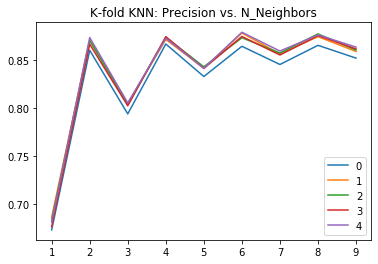

In [41]:
def knnmodeler(n):
  model = sklearnKNeighborsClassifier(n_neighbors=n)
  scores = cross_val_score(model,X,y,cv=5, scoring='precision')
  knn_n_dict[n] = scores
  
n_ls = [x for x in range(1,10)]
for n in n_ls:
  knnmodeler(n)
pd.DataFrame.from_dict(knn_n_dict, orient='index').plot(title='K-fold KNN: Precision vs. N_Neighbors')

In [42]:
acc_scores = cross_val_score(sklearnKNeighborsClassifier(n_neighbors=6),X,y,cv=5,scoring='accuracy')
prec_scores = cross_val_score(sklearnKNeighborsClassifier(n_neighbors=6),X,y,cv=5,scoring='precision')
f1_scores = cross_val_score(sklearnKNeighborsClassifier(n_neighbors=6),X,y,cv=5,scoring='f1')
rec_scores = cross_val_score(sklearnKNeighborsClassifier(n_neighbors=6),X,y,cv=5,scoring='recall')

print("Average 6-KNN Accuracy Score: ",np.mean(acc_scores))
print("Average 6-KNN Precision Score: ",np.mean(prec_scores))
print("Average 6-KNN F1-Score: ",np.mean(f1_scores))
print("Average 6-KNN Recall Score: ",np.mean(rec_scores))

Average 6-KNN Accuracy Score: 0.8870201190159502
Average 6-KNN Precision Score: 0.8735560741023989
Average 6-KNN F1-Score: 0.7158406057130912
Average 6-KNN Recall Score: 0.606380673890421

In [43]:
def stack_model(X_train,y_train, X_test):
  knn_model = sklearnKNeighborsClassifier(n_neighbors=6).fit(X_train,y_train)
  knn_model_pred_train = knn_model.predict(X_train)
  knn_model_pred_test = knn_model.predict(X_test)
  
  randfor_model = sklearnRandomForestClassifier(random_state=random_state, max_leaf_nodes=10, n_estimators=10).fit(X_train,y_train)
  randfor_pred_train = randfor_model.predict(X_train)
  randfor_pred_test = randfor_model.predict(X_test)

  logreg_l2_model = sklearnLogisticRegression(random_state=random_state, solver='liblinear',penalty='l2').fit(X_train,y_train)
  logreg_l2_pred_train = logreg_l2_model.predict(X_train)
  logreg_l2_pred_test = logreg_l2_model.predict(X_test)
  
  return list(zip(logreg_l2_pred_train, randfor_pred_train, knn_model_pred_train)),\
         list(zip(logreg_l2_pred_test, randfor_pred_test, knn_model_pred_test))

In [44]:
stacked_x_vars_train, stacked_x_vars_test = stack_model(X_train, y_train, X_test)
stacked_model = tree.DecisionTreeClassifier(random_state=random_state).fit(stacked_x_vars_train,y_train)

stacked_model_pred = stacked_model.predict(stacked_x_vars_test)
print("Stacked Model Accuracy score: ",accuracy_score(y_test,stacked_model_pred))
print("Stacked Model Precision score: ",precision_score(y_test,stacked_model_pred))
print("Stacked Model F1-score: ",f1_score(y_test,stacked_model_pred))
print("Stacked Model Recall score: ",recall_score(y_test,stacked_model_pred))

Stacked Model Accuracy score: 0.8905884239217573
Stacked Model Precision score: 0.8731481481481481
Stacked Model F1-score: 0.7343092976171937
Stacked Model Recall score: 0.6335662456328944

##Full Dataset Spark Pipeline

##Airlines Clean-up

In [47]:
#airlines['DEP_DEL15'] = airlines['DEP_DEL15'].fillna(0)
airlines.fillna(0, subset=['DEP_DEL15'])
#airlines['DELAY_15'] = airlines.DEP_DEL15
airlines = airlines.withColumn("DELAY_15", f.col("DEP_DEL15"))

In [48]:
#cancel_index = airlines.loc[airlines['CANCELLED'] == 1].index
#airlines.iloc[cancel_index,-1] = 0
airlines = airlines.withColumn('DELAY_15',when(airlines.CANCELLED == 1, 0))

In [49]:
del_list_time_period = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK']
airlines = airlines.drop(*del_list_time_period)

In [50]:
del_list_origin = ['ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC']
airlines = airlines.drop(*del_list_origin)

In [51]:
# delete destination related redundant variables
del_list_dest = ['DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC']
airlines = airlines.drop(*del_list_dest)

In [52]:
del_list_dest_perf = ['DEP_DELAY', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK']
airlines = airlines.drop(*del_list_dest_perf)

In [53]:
# delete arrival performance related redundant variables
del_list_arr_perf = ['ARR_DELAY', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK']
airlines = airlines.drop(*del_list_arr_perf)

In [54]:
airlines = airlines.drop('DISTANCE_GROUP')

In [55]:
del_list_div_info = ['DIV4_AIRPORT', 'DIV4_AIRPORT_ID', 'DIV4_AIRPORT_SEQ_ID', 'DIV4_WHEELS_ON', 'DIV4_TOTAL_GTIME', 'DIV4_LONGEST_GTIME', 'DIV4_WHEELS_OFF', 'DIV4_TAIL_NUM', 'DIV5_AIRPORT', 'DIV5_AIRPORT_ID', 'DIV5_AIRPORT_SEQ_ID', 'DIV5_WHEELS_ON', 'DIV5_TOTAL_GTIME', 'DIV5_LONGEST_GTIME', 'DIV5_WHEELS_OFF', 'DIV5_TAIL_NUM']
airlines = airlines.drop(*del_list_div_info)

In [56]:
# delete outcome related variables
del_list_outcome_related = ['DEP_DELAY_NEW', 'ARR_DELAY_NEW']
airlines = airlines.drop(*del_list_outcome_related)

In [57]:
airlines_eda = airlines.toPandas()

In [58]:
## New Correlation Matrix
air_corr = airlines_eda.corr()
fig, ax = plt.subplots(figsize=(15, 15))
mask = np.zeros_like(air_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sn.diverging_palette(240, 10, as_cmap=True)
sn.heatmap(air_corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
display(plt.show())

In [59]:
airlines = airlines.withColumn("ADJ_DEP_TIME", col('DEP_TIME'))
airlines = airlines.filter(length(airlines.ADJ_DEP_TIME) != 0)
airlines = airlines.filter(airlines.CANCELLED == 0.0)
airlines = airlines.withColumn('DEP_HOUR', when(length(col('ADJ_DEP_TIME')) == 3, airlines.ADJ_DEP_TIME.substr(1,1)).otherwise(airlines.ADJ_DEP_TIME.substr(1,2)))

In [60]:
airlines = airlines.withColumn('CANCELLATION_CODE', when(col('CANCELLATION_CODE') != "", col('CANCELLATION_CODE')).otherwise(0))
airlines = airlines.withColumn('DIV_DISTANCE', when(col('DIV_DISTANCE') != "", col('DIV_DISTANCE')).otherwise(0))
airlines = airlines.withColumn('DIV1_WHEELS_OFF', when(col('DIV1_WHEELS_OFF') != "", col('DIV1_WHEELS_OFF')).otherwise(0))
airlines = airlines.withColumn('DIV1_AIRPORT', when(col('DIV1_AIRPORT') != "", col('DIV1_AIRPORT')).otherwise(0))
airlines = airlines.withColumn('DIV2_WHEELS_OFF', when(col('DIV2_WHEELS_OFF') != "", col('DIV2_WHEELS_OFF')).otherwise(0))
airlines = airlines.withColumn('DIV2_AIRPORT', when(col('DIV2_AIRPORT') != "", col('DIV2_AIRPORT')).otherwise(0))
airlines = airlines.withColumn('DIV3_WHEELS_OFF', when(col('DIV3_WHEELS_OFF') != "", col('DIV3_WHEELS_OFF')).otherwise(0))
airlines = airlines.withColumn('DIV3_AIRPORT', when(col('DIV3_AIRPORT') != "", col('DIV3_AIRPORT')).otherwise(0))
airlines = airlines.withColumn('DIV1_TAIL_NUM', when(col('DIV1_TAIL_NUM') != "", col('DIV1_TAIL_NUM')).otherwise(0))
airlines = airlines.withColumn('DIV2_TAIL_NUM', when(col('DIV2_TAIL_NUM') != "", col('DIV2_TAIL_NUM')).otherwise(0))
airlines = airlines.withColumn('DIV3_TAIL_NUM', when(col('DIV3_TAIL_NUM') != "", col('DIV3_TAIL_NUM')).otherwise(0))
airlines = airlines.fillna(0)

In [61]:
airlines.drop('DIV1_TAIL_NUM')
airlines.drop('DIV2_TAIL_NUM')
airlines.drop('DIV3_TAIL_NUM')

In [62]:
#String Index and OneHot Encoding for the label columns
label_columns_air = ('ORIGIN', 'DEP_HOUR', 'OP_UNIQUE_CARRIER', 'DEST', 'CANCELLATION_CODE', 'DIV1_AIRPORT')
stringIndexer_air = [StringIndexer(inputCol=col, outputCol=col+"_INDEX", handleInvalid = "keep") for col in label_columns_air]
encoder_air = [OneHotEncoder(inputCol=col.getOutputCol(), outputCol="{0}_encoded".format(col.getOutputCol())) for col in stringIndexer_air]

In [63]:
pipe_stages_air = []
pipe_stages_air.extend(stringIndexer_air)
pipe_stages_air.extend(encoder_air)

In [64]:
pipeline_air = Pipeline(stages=pipe_stages_air)
airlines = pipeline_air.fit(airlines).transform(airlines)

In [65]:
# Standardize continuous variables
air_cont = ['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE']
#Standard Scaler
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec", handleInvalid='keep') for col in air_cont]
scalers = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in air_cont]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel_airlines = pipeline.fit(airlines)
scaledData_airlines = scalerModel_airlines.transform(airlines)

##Weather Clean-up

In [67]:
## Weather data work
weather = weather.filter(length(trim(weather.CALL_SIGN)) < 5)
weather = weather.withColumn("ORIGIN", trim(col('CALL_SIGN')).substr(2,3))

In [68]:
cols_to_delete = ['GA4','MW2','OD2','GN1','GG3','AU5','HL1','OB1','AT8','AW7','AZ1','CH1','GK1','IB1','CT1','CN2','MW5','AO1','CR1','CF2','GM1','AY2','MW6',
                 'AL2','AL3','AX5','IB2','CV3','GH1','KF1','CU2','CT3','SA1','GO1','CG3','AL1','AW6','MW4','AX6','CV1','ME1','CN1','UA1','GD5','UG2','GJ1','MV1',
                 'GA5','CT2','CG2','CO1','MW3','AY1','CU3','GA6','GL1','IA1','GG2','OD3','UG1','CB1','CI1','CV2','AZ2','WD1','AA4','IA2','CF3','CU1','CN4','CG1',
                 'CF1','GG1','MV2','CW1','GG4','CN3','QUALITY_CONTROL']
weather = weather.drop(*cols_to_delete)

In [69]:
cols_to_delete1 = ['AB1','AD1','AE1','AK1','AH1','AH2','AH3','AH4','AH5','AH6','AI1','AI2','AI3','AI4',"AI5",'AI6','AM1','AU1','AU2','AU3','AU4',"AW1",'AW2','AW3','AW4','AW5','KC1','KC2','KD1',
                   'KD2','KE1','KG1','KG2','GA1','GA2','GA3','GE1','GF1','MH1','MG1','MK1','MW1','OD1']
weather = weather.drop(*cols_to_delete1)

In [70]:
# Add 2 hours in weather data because we want the predict the delay 2 hours before departure. Add DEP_HOUR and DEP_DATE columns in weather to represent the departure time
weather = weather.withColumn('DEP_HOUR', hour(weather.DATE + f.expr('INTERVAL 2 HOURS')))
weather = weather.withColumn('FL_DATE', to_date(weather.DATE + f.expr('INTERVAL 2 HOURS')))

In [71]:
weather = weather.withColumn('AA', f.concat('AA1', 'AA2', 'AA3'))
weather = weather.withColumn('AT', f.concat('AT1', 'AT2', 'AT3', 'AT4', 'AT5', 'AT6', 'AT7'))
weather = weather.withColumn('AX', f.concat('AX1', 'AX2', 'AX3', 'AX4'))
weather = weather.withColumn('GD', f.concat('GD1', 'GD2', 'GD3', 'GD4'))
weather = weather.withColumn('KA', f.concat('KA1', 'KA2', 'KA3', 'KA4'))
weather = weather.withColumn('KB', f.concat('KB1', 'KB2', 'KB3'))
weather = weather.withColumn('OE', f.concat('OE1', 'OE2', 'OE3'))
weather = weather.withColumn('RH', f.concat('RH1', 'RH2', 'RH3'))

In [72]:
cols_to_delete2 = ['AA1', 'AA2', 'AA3', 'AT1', 'AT2', 'AT3', 'AT4', 'AT5', 'AT6', 'AT7', 'AX1', 'AX2', 'AX3', 'AX4', 'GD1', 'GD2', 'GD3', 'GD4', 
                  'KA1', 'KA2', 'KA3', 'KA4', 'KB1', 'KB2', 'KB3', 'OE1', 'OE2', 'OE3', 'RH1', 'RH2', 'RH3']
weather = weather.drop(*cols_to_delete2)

In [73]:
weather = weather.withColumn('AJ1', split(col('AJ1'), ',').getItem(0))
weather = weather.withColumn('AX', split(col('AX'), ',').getItem(0))
weather = weather.withColumn('GD', split(col('GD'), ',').getItem(0))
weather = weather.withColumn('MF1', split(col('MF1'), ',').getItem(0))
weather = weather.withColumn('OC1', split(col('OC1'), ',').getItem(0))
weather = weather.withColumn('CIG', split(col('CIG'), ',').getItem(0))
weather = weather.withColumn('VIS', split(col('VIS'), ',').getItem(0))

weather = weather.withColumn('AA', split(col('AA'), ',').getItem(1))
weather = weather.withColumn('AN1', split(col('AN1'), ',').getItem(1))
weather = weather.withColumn('AT', split(col('AT'), ',').getItem(1))
weather = weather.withColumn('WA1', split(col('WA1'), ',').getItem(1))

weather = weather.withColumn('RH', split(col('RH'), ',').getItem(2))
weather = weather.withColumn('OE', split(col('OE'), ',').getItem(2))
weather = weather.withColumn('MA1', split(col('MA1'), ',').getItem(2))
weather = weather.withColumn('MD1', split(col('MD1'), ',').getItem(2))
weather = weather.withColumn('KB', split(col('KB'), ',').getItem(2))
weather = weather.withColumn('KA', split(col('KA'), ',').getItem(2))
weather = weather.withColumn('ED1', split(col('ED1'), ',').getItem(2))

weather = weather.withColumn('WND', split(col('WND'), ',').getItem(3))

In [74]:
weather = weather.withColumn('OC1', when(col('OC1') == '', 0).otherwise(col('OC1')))
weather = weather.withColumn('EQD', when(col('EQD') == '', 0).otherwise(col('EQD')))
weather = weather.withColumn('AJ1', when(col('AJ1') == '', 0).otherwise(col('AJ1')))
weather = weather.withColumn('MF1', when(col('MF1') == '', 0).otherwise(col('MF1')))
weather = weather.withColumn('AX', when(col('AX') == '', 0).otherwise(col('AX')))
weather = weather.withColumn('GD', when(col('GD') == '', 0).otherwise(col('GD')))

In [75]:
weather = weather.withColumn('AN1', when((col('AN1') != ""), 'AN1').otherwise(0))
weather = weather.withColumn('WA1', when((col('WA1') != ""), 'WA1').otherwise(0))
weather = weather.withColumn('ED1', when((col('ED1') != ""), 'ED1').otherwise(0))
weather = weather.withColumn('AA', when((col('AA') != ""), 'AA').otherwise(0))
weather = weather.withColumn('AT', when((col('AT') != ""), 'AT').otherwise(0))
weather = weather.withColumn('KA', when((col('KA') != ""), 'KA').otherwise(0))
weather = weather.withColumn('KB', when((col('KB') != ""), 'KB').otherwise(0))
weather = weather.withColumn('OE', when((col('OE') != ""), 'OE').otherwise(0))
weather = weather.withColumn('RH', when((col('RH') != ""), 'RH').otherwise(0))

In [76]:
#NEED TO CONVERT TO STRINGS
weather = weather.withColumn('AA', col('AA').cast("float"))
weather = weather.withColumn('AJ1', col('AJ1').cast("float"))
weather = weather.withColumn('ED1', col('ED1').cast("float"))
weather = weather.withColumn('KA', col('KA').cast("float"))
weather = weather.withColumn('KB', col('KB').cast("float"))
weather = weather.withColumn('MA1', col('MA1').cast("float"))
weather = weather.withColumn('MD1', col('MD1').cast("float"))
weather = weather.withColumn('MF1', col('MF1').cast("float"))
weather = weather.withColumn('OC1', col('OC1').cast("float"))
weather = weather.withColumn('OE', col('OE').cast("float"))
weather = weather.withColumn('RH', col('RH').cast("float"))
weather = weather.withColumn('WA1', col('WA1').cast("float"))

In [77]:
wtr_cont = ['AA','AJ1','ED1','KA','KB','MA1','MD1','MF1','OC1','OE','RH','WA1']

In [78]:
#String Indexers and OneHot Encoding
label_columns_wtr = ('REPORT_TYPE', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP', 'EQD', 'AN1', 'AT', 'AX', 'GD')
stringIndexer_wtr = [StringIndexer(inputCol=col, outputCol=col+"_INDEX", handleInvalid = "keep") for col in label_columns_wtr]
encoder_wtr = [OneHotEncoder(inputCol=col.getOutputCol(), outputCol="{0}_encoded".format(col.getOutputCol())) for col in stringIndexer_wtr]

In [79]:
pipe_stages_wtr = []
pipe_stages_wtr.extend(stringIndexer_wtr)
pipe_stages_wtr.extend(encoder_wtr)

In [80]:
pipeline_wtr = Pipeline(stages=pipe_stages_wtr)
weather = pipeline_wtr.fit(weather).transform(weather)

In [81]:
#Standard Scaler
weather = weather.fillna(0)
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec", handleInvalid='keep') for col in wtr_cont]
scalers = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in wtr_cont]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel_weather = pipeline.fit(weather)
scaledData_weather = scalerModel_weather.transform(weather)

##Join Data

In [83]:
data = scaledData_airlines.join(scaledData_weather, on = ['ORIGIN', 'FL_DATE', 'DEP_HOUR'])
data = data.fillna(0)

cols_to_drop = ('FL_DATE', 'OP_CARRIER', 'TAIL_NUM', 'CALL_SIGN', 'DIV3_WHEELS_OFF', 'STATION', 'NAME', 'DIV2_AIRPORT', 'DIV3_AIRPORT', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE', 'AA', 'AJ1', 'ED1', 'KA', 'KB', 'MA1', 'MD1', 'MF1', 'OC1', 'OE', 'RH', 'WA1')
data.drop(*cols_to_drop)

In [84]:
#sampleData, restData = data.randomSplit([0.0005, 0.9995], seed = 42)

In [85]:
label_columns = ('ORIGIN', 'DEP_HOUR', 'OP_UNIQUE_CARRIER', 'DEST', 'CANCELLATION_CODE', 'DIV1_AIRPORT', 'REPORT_TYPE', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP', 'REM', 'EQD', 'AN1', 'AT', 'AX', 'GD',  'STATION',  'SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'CALL_SIGN', 'MA1', 'MD1', 'OC1', 'AJ1', 'MF1', 'WA1', 'ED1', 'AA', 'KA', 'KB', 'OE',  'RH','FL_DATE',
 'OP_CARRIER_AIRLINE_ID',  'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'DIV_AIRPORT_LANDINGS', 'DIV_REACHED_DEST', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE', 'DIV1_AIRPORT_ID', 'DIV1_AIRPORT_SEQ_ID', 'DIV1_WHEELS_ON', 'DIV1_TOTAL_GTIME', 'DIV1_LONGEST_GTIME', 'DIV1_WHEELS_OFF', 'DIV1_TAIL_NUM', 'DIV2_AIRPORT', 'DIV2_AIRPORT_ID', 'DIV2_AIRPORT_SEQ_ID', 'DIV2_WHEELS_ON', 'DIV2_TOTAL_GTIME', 'DIV2_LONGEST_GTIME', 'DIV2_WHEELS_OFF', 'DIV2_TAIL_NUM', 'DIV3_AIRPORT', 'DIV3_AIRPORT_ID', 'DIV3_AIRPORT_SEQ_ID', 'DIV3_WHEELS_ON', 'DIV3_TOTAL_GTIME', 'DIV3_LONGEST_GTIME', 'DIV3_WHEELS_OFF', 'DIV3_TAIL_NUM', 'ADJ_DEP_TIME',  'AA_vec', 'AJ1_vec', 'ED1_vec', 'KA_vec', 'KB_vec', 'MA1_vec', 'MD1_vec', 'MF1_vec', 'OC1_vec', 'OE_vec', 'RH_vec', 'WA1_vec',  'REPORT_TYPE_INDEX', 'WND_INDEX', 'CIG_INDEX', 'VIS_INDEX', 'TMP_INDEX', 'DEW_INDEX', 'SLP_INDEX', 'EQD_INDEX', 'AN1_INDEX', 'AT_INDEX', 'AX_INDEX', 'GD_INDEX', 'ORIGIN_INDEX', 'DEP_HOUR_INDEX', 'OP_UNIQUE_CARRIER_INDEX', 'DEST_INDEX', 'CANCELLATION_CODE_INDEX', 'DIV1_AIRPORT_INDEX', 'CRS_ELAPSED_TIME_vec', 'ACTUAL_ELAPSED_TIME_vec', 'AIR_TIME_vec', 'DISTANCE_vec', 'CARRIER_DELAY_vec', 'WEATHER_DELAY_vec', 'NAS_DELAY_vec', 'SECURITY_DELAY_vec', 'LATE_AIRCRAFT_DELAY_vec', 'DIV_ACTUAL_ELAPSED_TIME_vec', 'DIV_ARR_DELAY_vec', 'DIV_DISTANCE_vec')
feature_columns = data.columns
feature_columns.remove('DELAY_15')
feature_columns.remove('DATE')
feature_cols = [x for x in feature_columns if x not in label_columns]

#Index each label
#stringIndex = [StringIndexer(inputCol=col, outputCol=col+"_INDEX", handleInvalid = "keep").fit(sampleData).transform(sampleData) for col in label_columns]
#stringIndexer = [StringIndexer(inputCol=col, outputCol=col+"_INDEX", handleInvalid = "keep") for col in label_columns]
#encoder = [OneHotEncoder(inputCol=col.getOutputCol(), outputCol="{0}_encoded".format(col.getOutputCol())) for col in stringIndexer]

In [86]:
#Vector transforms
featureAssembler = VectorAssembler(inputCols=feature_cols, outputCol= "features", handleInvalid = "keep")
#Automatically categorize variables buckets = 10 for now
#featureVectorizer = VectorIndexer(inputCol="feature_vec", outputCol="features", handleInvalid = "keep", maxCategories=10)
#Splits for training, test and holdout
trainingData, testData, holdoutData = data.randomSplit([0.6, 0.2, 0.2], seed = 42)

##Spark Models

##Logistic Regression

In [89]:
lr = LogisticRegression(featuresCol = "features", labelCol = "DELAY_15", maxIter=10, regParam=0.3, elasticNetParam=0.8)
pipe_stages_lr = []
pipe_stages_lr.extend([featureAssembler])
#pipe_stages_lr.extend([featureVectorizer])
pipe_stages_lr.extend([lr])

pipeline_lr = Pipeline(stages=pipe_stages_lr)
model_lr = pipeline_lr.fit(trainingData)

In [90]:
predictions_lr = model_lr.transform(testData)
predictions_lr.select("prediction", "DELAY_15", "features").show(5)

##Decision Tree Classifier

In [92]:
dt = DecisionTreeClassifier(labelCol="DELAY_15", featuresCol="features")
#Assemble the stages into a singular list
pipe_stages_dt = []
pipe_stages_dt.extend([featureAssembler])
#pipe_stages_dt.extend([featureVectorizer])
pipe_stages_dt.extend([dt])

pipeline_dt = Pipeline(stages=pipe_stages_dt)
model_dt = pipeline_dt.fit(trainingData)

predictions_dt = model_dt.transform(testData)
predictions_dt.select("prediction", "DELAY_15", "features").show(5)

In [93]:
# Select (prediction, true label) and compute test error
evaluator_dt = MulticlassClassificationEvaluator(
    labelCol="DELAY_15", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator_dt.evaluate(predictions_dt)
print("Test Error = %g " % (1.0 - accuracy_dt))

treeModel_dt = model.stages[2]
print(treeModel)

##Random Forest Classifier

In [95]:
rf = RandomForestClassifier(labelCol="DELAY_15", featuresCol="features", numTrees=10)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel")
#Assemble the stages into a singular list
pipe_stages_rf = []
pipe_stages_rf.extend([featureAssembler])
#pipe_stages_rf.extend([featureVectorizer])
pipe_stages_rf.extend([rf])
pipe_stages_rf.extend([labelConverter])

pipeline_rf = Pipeline(stages=pipe_stages_rf)
model_rf = pipeline_rf.fit(trainingData)


predictions_rf = model_rf.transform(testData)
predictions_rf.select("predictedLabel", "DELAY_15", "features").show(5)

In [96]:
# Select (prediction, true label) and compute test error
evaluator_rf = MulticlassClassificationEvaluator(
    labelCol="DELAY_15", predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator_rf.evaluate(predictions_rf)
print("Test Error = %g" % (1.0 - accuracy_rf))

rfModel = model_rf.stages[2]
print(rfModel)  # summary only

##Gradient Boosted Trees

In [98]:
gbt = GBTClassifier(labelCol="DELAY_15", featuresCol="features", maxIter=10)

pipe_stages_gbt = []
pipe_stages_gbt.extend([featureAssembler])
#pipe_stages_gbt.extend([featureVectorizer])
pipe_stages_gbt.extend([gbt])


pipeline_gbt = Pipeline(stages=pipe_stages_gbt)
model_gbt = pipeline_gbt.fit(trainData)


predictions_gbt = model_gbt.transform(testData)
predictions_gbt.select("prediction", "DELAY_15", "features").show(5)

In [99]:
# Select (prediction, true label) and compute test error
evaluator_gbt = MulticlassClassificationEvaluator(
    labelCol="DELAY_15", predictionCol="prediction", metricName="accuracy")
accuracy_gbt = evaluator_gbt.evaluate(predictions_gbt)
print("Test Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only